# R3: Full E vs Reduced E - How Additional Information Changes Predictions

## Purpose

This notebook compares predictions made with:

1. **Full E matrix** (`enrollment_predictions_fixedphi_RETROSPECTIVE_pooled_withfullE`): Predictions made using the complete E matrix (seeing all disease information)
2. **Reduced E matrix** (`enrollment_predictions_fixedphi_RETROSPECTIVE_pooled`): Predictions made using a reduced E matrix (standard enrollment approach)

**Key Question**: How do predictions change for patients who develop diseases **after enrollment** when we have access to more information (full E) vs less information (reduced E)?

## Expected Findings

- Patients who develop diseases after enrollment should show **updated predictions** in the full E version
- The full E version should better reflect their actual disease progression
- This demonstrates how Aladynoulli can incorporate new information as it becomes available


## 1. Load Data and Setup


In [17]:
import torch
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("COMPARING FULL E vs REDUCED E PREDICTIONS")
print("="*80)

# Paths
base_dir = Path("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal")

# Full E predictions
pi_fullE_path = base_dir / "enrollment_predictions_fixedphi_RETROSPECTIVE_pooled_withfullE" / "pi_enroll_fixedphi_sex_FULL.pt"

# Reduced E predictions
pi_reducedE_path = base_dir / "enrollment_predictions_fixedphi_RETROSPECTIVE_pooled" / "pi_enroll_fixedphi_sex_FULL.pt"

# Data files
Y_path = base_dir / "data_for_running" / "Y_tensor.pt"
E_path = base_dir / "data_for_running" / "E_matrix.pt"
E_enrollment_path = base_dir / "data_for_running" / "E_enrollment_full.pt"  # Enrollment E matrix
disease_names_path = base_dir / "data_for_running" / "disease_names.csv"

# Load pi predictions
print("\nLoading pi predictions...")
if pi_fullE_path.exists():
    pi_fullE = torch.load(str(pi_fullE_path), weights_only=False)
    print(f"✓ Loaded Full E predictions: {pi_fullE.shape}")
else:
    print(f"⚠️  Full E file not found: {pi_fullE_path}")
    pi_fullE = None

if pi_reducedE_path.exists():
    pi_reducedE = torch.load(str(pi_reducedE_path), weights_only=False)
    print(f"✓ Loaded Reduced E predictions: {pi_reducedE.shape}")
else:
    print(f"⚠️  Reduced E file not found: {pi_reducedE_path}")
    pi_reducedE = None

# Load disease names
if disease_names_path.exists():
    disease_names_df = pd.read_csv(disease_names_path)
    disease_names = disease_names_df.iloc[:, 1].tolist()
    if len(disease_names) > 0 and str(disease_names[0]).lower() == 'x':
        disease_names = disease_names[1:]
    disease_names = [str(name) if pd.notna(name) else f"Disease_{i}" for i, name in enumerate(disease_names)]
    print(f"✓ Loaded {len(disease_names)} disease names")
else:
    disease_names = [f"Disease_{i}" for i in range(pi_fullE.shape[1] if pi_fullE is not None else 348)]
    print("⚠️  Using placeholder disease names")

# Load E matrices
print("\nLoading E matrices...")
if E_path.exists():
    E_full = torch.load(str(E_path), weights_only=False)
    print(f"✓ Loaded full E matrix: {E_full.shape}")
else:
    print(f"⚠️  E matrix not found: {E_path}")
    E_full = None

if E_enrollment_path.exists():
    E_enrollment = torch.load(str(E_enrollment_path), weights_only=False)
    print(f"✓ Loaded enrollment E matrix: {E_enrollment.shape}")
else:
    print(f"⚠️  Enrollment E matrix not found: {E_enrollment_path}")
    E_enrollment = None


COMPARING FULL E vs REDUCED E PREDICTIONS

Loading pi predictions...
✓ Loaded Full E predictions: torch.Size([400000, 348, 52])
✓ Loaded Reduced E predictions: torch.Size([400000, 348, 52])
✓ Loaded 348 disease names

Loading E matrices...
✓ Loaded full E matrix: torch.Size([407878, 348])
✓ Loaded enrollment E matrix: torch.Size([407878, 348])


## 2. Identify Patients with Post-Enrollment Diseases


In [18]:
# Find patients who develop diseases AFTER enrollment
# E_enrollment_full.pt censors E_matrix.pt at each patient's enrollment age
# So we need to load enrollment ages and check for diseases that occur after enrollment

if E_full is not None and E_enrollment is not None:
    print("\n" + "="*80)
    print("IDENTIFYING PATIENTS WITH POST-ENROLLMENT DISEASES")
    print("="*80)
    
    # Load enrollment ages from CSV
    csv_path = base_dir / "baselinagefamh_withpcs.csv"
    if csv_path.exists():
        print("\nLoading enrollment ages from CSV...")
        fh_processed = pd.read_csv(csv_path)
        print(f"✓ Loaded {len(fh_processed)} patients from CSV")
    else:
        print(f"\n⚠️  CSV not found: {csv_path}")
        fh_processed = None
    
    if fh_processed is not None:
        post_enrollment_patients = []
        
        # Check first 100K patients (or all if smaller)
        n_patients = min(100000, len(E_full), len(E_enrollment), len(fh_processed))
        
        print(f"\nChecking first {n_patients} patients...")
        
        for patient_idx in range(n_patients):
            if patient_idx >= len(fh_processed):
                break
            
            # Get enrollment age for this patient
            enrollment_age = fh_processed.iloc[patient_idx]['age']
            enrollment_time = max(0, enrollment_age - 30)  # Time since age 30 (timepoint 0)
            
            E_full_patient = E_full[patient_idx]
            E_enroll_patient = E_enrollment[patient_idx]
            
            # Find diseases that occur AFTER enrollment
            # - E_matrix (full) has event time > enrollment_time (actual event after enrollment)
            # - E_enrollment has event time = enrollment_time (censored at enrollment)
            post_enroll_diseases = []
            
            for d_idx in range(len(E_full_patient)):
                full_time = E_full_patient[d_idx].item()
                enroll_time = E_enroll_patient[d_idx].item()
                
                # Disease occurred after enrollment if:
                # - Full E shows event time > enrollment_time (disease occurred after enrollment)
                # - Enrollment E shows event time = enrollment_time (censored at enrollment)
                # - Full time should be < 51 (actual event, not censored)
                if (full_time > enrollment_time and 
                    full_time < 51 and 
                    abs(enroll_time - enrollment_time) < 0.01):  # Allow small floating point differences
                    post_enroll_diseases.append((d_idx, full_time, enroll_time, enrollment_time))
            
            if len(post_enroll_diseases) > 0:
                post_enrollment_patients.append((patient_idx, post_enroll_diseases, enrollment_age))
        
        print(f"\n✓ Found {len(post_enrollment_patients)} patients with post-enrollment diseases")
        print(f"   (out of {n_patients} patients checked)")
        
        # Show some examples
        if len(post_enrollment_patients) > 0:
            print("\nExample patients with post-enrollment diseases:")
            for i, (patient_idx, diseases, enroll_age) in enumerate(post_enrollment_patients[:5]):
                print(f"\n  Patient {patient_idx}: enrollment age={enroll_age:.1f}, {len(diseases)} post-enrollment diseases")
                for d_idx, full_time, enroll_time, enroll_t in diseases[:3]:  # Show first 3
                    print(f"    - {disease_names[d_idx]}: Full E={full_time:.1f} (after enroll), Enrollment E={enroll_time:.1f} (censored at enroll)")
    else:
        print("\n⚠️  Cannot identify post-enrollment patients without enrollment ages")
        post_enrollment_patients = []
else:
    print("\n⚠️  Cannot identify post-enrollment patients without E matrices")
    post_enrollment_patients = []



IDENTIFYING PATIENTS WITH POST-ENROLLMENT DISEASES

Loading enrollment ages from CSV...
✓ Loaded 407878 patients from CSV

Checking first 100000 patients...

✓ Found 88829 patients with post-enrollment diseases
   (out of 100000 patients checked)

Example patients with post-enrollment diseases:

  Patient 0: enrollment age=69.0, 2 post-enrollment diseases
    - Asthma: Full E=44.0 (after enroll), Enrollment E=39.0 (censored at enroll)
    - Osteoarthrosis, localized, primary: Full E=44.0 (after enroll), Enrollment E=39.0 (censored at enroll)

  Patient 1: enrollment age=44.0, 2 post-enrollment diseases
    - Septal Deviations/Turbinate Hypertrophy: Full E=22.0 (after enroll), Enrollment E=14.0 (censored at enroll)
    - Other upper respiratory disease: Full E=23.0 (after enroll), Enrollment E=14.0 (censored at enroll)

  Patient 2: enrollment age=69.0, 3 post-enrollment diseases
    - GERD: Full E=40.0 (after enroll), Enrollment E=39.0 (censored at enroll)
    - Diaphragmatic hernia: 

## 3. Compare Predictions for Post-Enrollment Patients


In [19]:
# Compare predictions for patients with post-enrollment diseases

if pi_fullE is not None and pi_reducedE is not None and len(post_enrollment_patients) > 0:
    print("\n" + "="*80)
    print("COMPARING PREDICTIONS FOR POST-ENROLLMENT PATIENTS")
    print("="*80)
    
    # Analyze first 100 patients with post-enrollment diseases
    n_analyze = min(100, len(post_enrollment_patients))
    
    prediction_differences = []
    
    for patient_idx, diseases, enroll_age in post_enrollment_patients[:n_analyze]:
        # Get predictions at enrollment (timepoint 0)
        pi_fullE_patient = pi_fullE[patient_idx]
        pi_reducedE_patient = pi_reducedE[patient_idx]
        
        # Compare predictions for diseases that occur post-enrollment
        for d_idx, full_time, enroll_time, enroll_t in diseases:
            # Predictions at enrollment (time 0)
            pred_fullE = pi_fullE_patient[d_idx, 0].item()
            pred_reducedE = pi_reducedE_patient[d_idx, 0].item()
            
            # Predictions at time of actual event (if within range)
            t_event = int(full_time)
            if t_event < pi_fullE_patient.shape[1]:
                pred_fullE_at_event = pi_fullE_patient[d_idx, t_event].item()
                pred_reducedE_at_event = pi_reducedE_patient[d_idx, t_event].item()
            else:
                pred_fullE_at_event = None
                pred_reducedE_at_event = None
            
            # Calculate time AFTER enrollment (not time since age 30)
            time_after_enrollment = full_time - enroll_t
            
            prediction_differences.append({
                'patient_idx': patient_idx,
                'disease_idx': d_idx,
                'disease_name': disease_names[d_idx],
                'event_time_since_30': full_time,  # Time since age 30
                'enrollment_time': enroll_t,  # Enrollment time (since age 30)
                'time_after_enrollment': time_after_enrollment,  # Time AFTER enrollment
                'pred_fullE_enroll': pred_fullE,
                'pred_reducedE_enroll': pred_reducedE,
                'pred_diff_enroll': pred_fullE - pred_reducedE,
                'pred_fullE_at_event': pred_fullE_at_event,
                'pred_reducedE_at_event': pred_reducedE_at_event,
                'pred_diff_at_event': (pred_fullE_at_event - pred_reducedE_at_event) if (pred_fullE_at_event is not None and pred_reducedE_at_event is not None) else None
            })
    
    # Convert to DataFrame
    df_comparison = pd.DataFrame(prediction_differences)
    
    print(f"\n✓ Analyzed {len(df_comparison)} disease predictions across {n_analyze} patients")
    print(f"\nSummary statistics:")
    print(f"  Mean prediction difference at enrollment: {df_comparison['pred_diff_enroll'].mean():.6f}")
    print(f"  Std prediction difference at enrollment: {df_comparison['pred_diff_enroll'].std():.6f}")
    print(f"  Max increase (Full E > Reduced E): {df_comparison['pred_diff_enroll'].max():.6f}")
    print(f"  Max decrease (Full E < Reduced E): {df_comparison['pred_diff_enroll'].min():.6f}")
    
    # Show top differences
    print(f"\nTop 10 diseases with largest prediction differences at enrollment:")
    top_diffs = df_comparison.nlargest(10, 'pred_diff_enroll')
    print("\n  Disease                          Patient  FullE    ReducedE  Difference")
    print("  " + "-"*75)
    for _, row in top_diffs.iterrows():
        print(f"  {row['disease_name'][:30]:30s} {row['patient_idx']:7d} {row['pred_fullE_enroll']:8.6f} {row['pred_reducedE_enroll']:8.6f} {row['pred_diff_enroll']:10.6f}")
    
    # Show diseases where Full E predicts higher risk
    increased_risk = df_comparison[df_comparison['pred_diff_enroll'] > 0.01]
    print(f"\n✓ {len(increased_risk)} predictions where Full E shows >0.01 higher risk")
    
    # Show diseases where Reduced E predicts higher risk
    decreased_risk = df_comparison[df_comparison['pred_diff_enroll'] < -0.01]
    print(f"✓ {len(decreased_risk)} predictions where Reduced E shows >0.01 higher risk")
    
else:
    print("\n⚠️  Cannot compare predictions - missing data")
    df_comparison = None



COMPARING PREDICTIONS FOR POST-ENROLLMENT PATIENTS

✓ Analyzed 723 disease predictions across 100 patients

Summary statistics:
  Mean prediction difference at enrollment: 0.000004
  Std prediction difference at enrollment: 0.000008
  Max increase (Full E > Reduced E): 0.000101
  Max decrease (Full E < Reduced E): -0.000009

Top 10 diseases with largest prediction differences at enrollment:

  Disease                          Patient  FullE    ReducedE  Difference
  ---------------------------------------------------------------------------
  Asthma                              57 0.000283 0.000182   0.000101
  Asthma                              19 0.000222 0.000167   0.000055
  Asthma                              86 0.000209 0.000163   0.000046
  Asthma                             102 0.000216 0.000172   0.000044
  Asthma                               0 0.000216 0.000174   0.000042
  Asthma                              38 0.000213 0.000172   0.000041
  Asthma                        

## 4. Visualize Prediction Differences


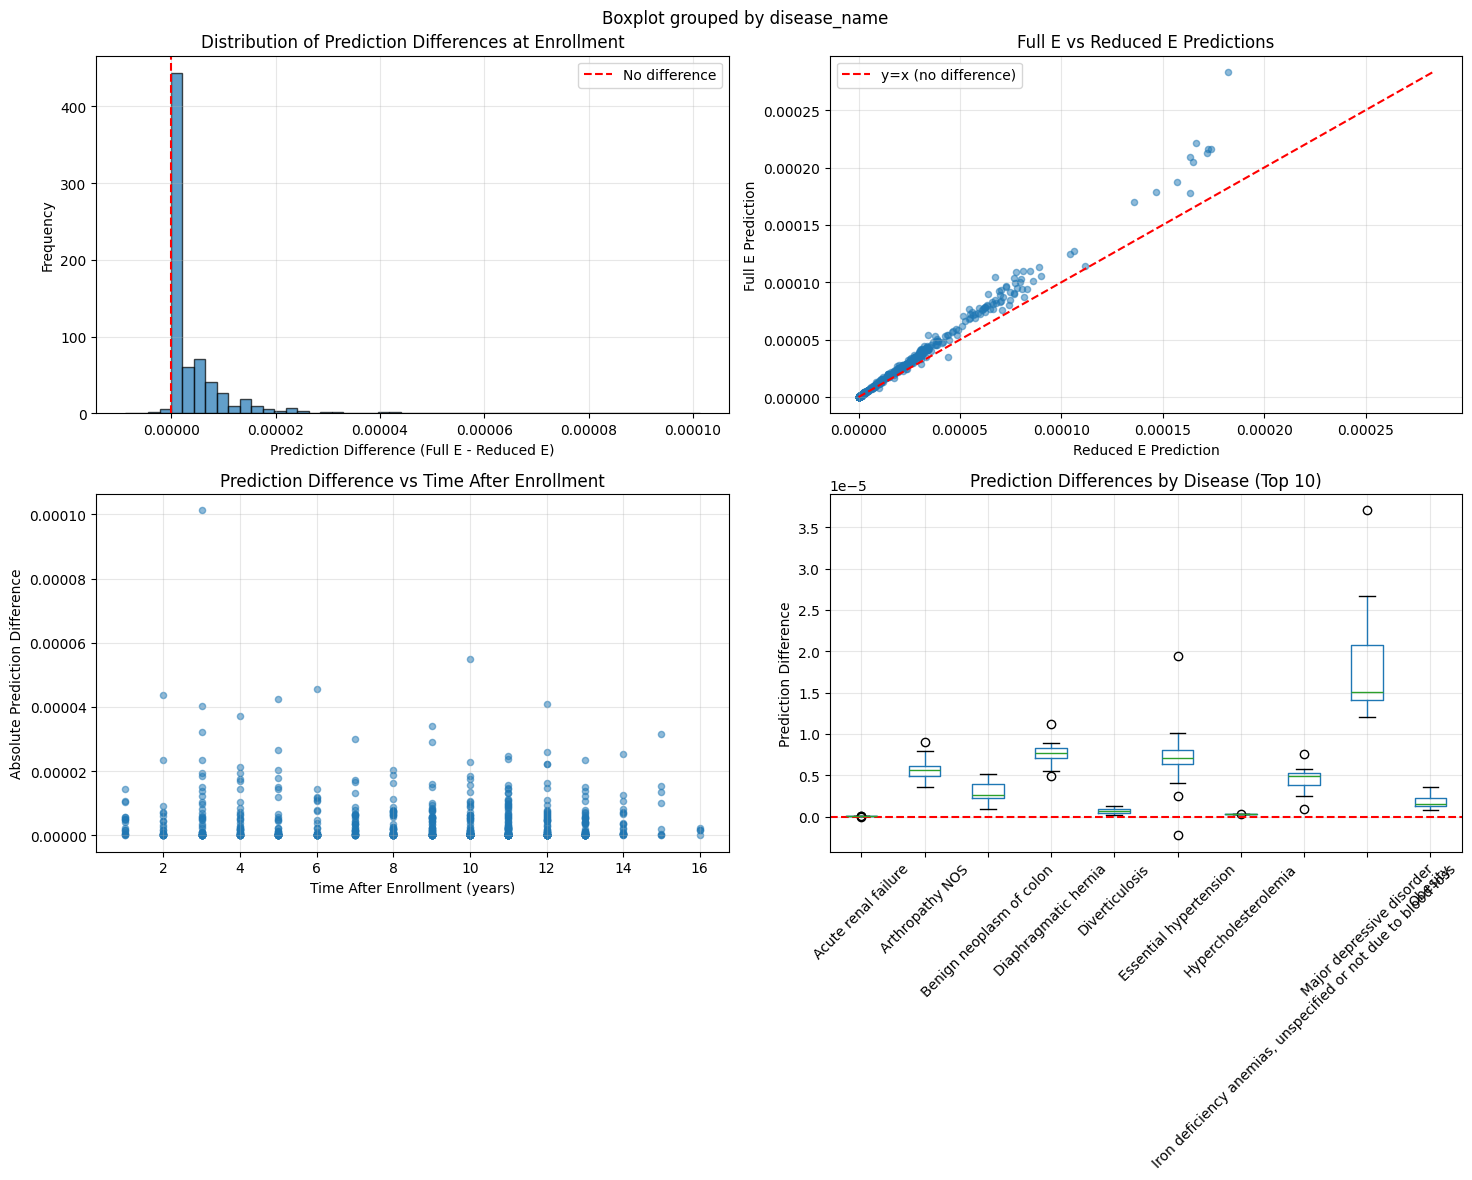


✓ Created visualization plots


In [20]:
# Create visualizations

if df_comparison is not None and len(df_comparison) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Distribution of prediction differences
    axes[0, 0].hist(df_comparison['pred_diff_enroll'], bins=50, edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(0, color='red', linestyle='--', label='No difference')
    axes[0, 0].set_xlabel('Prediction Difference (Full E - Reduced E)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Prediction Differences at Enrollment')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Scatter plot: Full E vs Reduced E predictions
    axes[0, 1].scatter(df_comparison['pred_reducedE_enroll'], df_comparison['pred_fullE_enroll'], 
                       alpha=0.5, s=20)
    max_val = max(df_comparison['pred_reducedE_enroll'].max(), df_comparison['pred_fullE_enroll'].max())
    axes[0, 1].plot([0, max_val], [0, max_val], 'r--', label='y=x (no difference)')
    axes[0, 1].set_xlabel('Reduced E Prediction')
    axes[0, 1].set_ylabel('Full E Prediction')
    axes[0, 1].set_title('Full E vs Reduced E Predictions')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Absolute difference vs time AFTER enrollment
    axes[1, 0].scatter(df_comparison['time_after_enrollment'], df_comparison['pred_diff_enroll'].abs(), 
                       alpha=0.5, s=20)
    axes[1, 0].set_xlabel('Time After Enrollment (years)')
    axes[1, 0].set_ylabel('Absolute Prediction Difference')
    axes[1, 0].set_title('Prediction Difference vs Time After Enrollment')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Box plot by disease (top 10 diseases)
    top_diseases = df_comparison.groupby('disease_name')['pred_diff_enroll'].count().nlargest(10).index
    df_top = df_comparison[df_comparison['disease_name'].isin(top_diseases)]
    df_top.boxplot(column='pred_diff_enroll', by='disease_name', ax=axes[1, 1], rot=45)
    axes[1, 1].axhline(0, color='red', linestyle='--')
    axes[1, 1].set_xlabel('')
    axes[1, 1].set_ylabel('Prediction Difference')
    axes[1, 1].set_title('Prediction Differences by Disease (Top 10)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Created visualization plots")
else:
    print("\n⚠️  Cannot create visualizations - no comparison data")


## 5. Case Studies: Individual Patients


In [21]:
# Show detailed case studies for a few patients

if df_comparison is not None and len(df_comparison) > 0:
    print("\n" + "="*80)
    print("CASE STUDIES: INDIVIDUAL PATIENTS")
    print("="*80)
    
    # Select patients with largest differences
    top_patients = df_comparison.nlargest(5, 'pred_diff_enroll')['patient_idx'].unique()[:3]
    
    for patient_idx in top_patients:
        patient_diseases = df_comparison[df_comparison['patient_idx'] == patient_idx]
        
        print(f"\n{'='*80}")
        print(f"PATIENT {patient_idx}")
        print(f"{'='*80}")
        print(f"Post-enrollment diseases: {len(patient_diseases)}")
        
        # Get full E and reduced E predictions
        pi_fullE_patient = pi_fullE[patient_idx]
        pi_reducedE_patient = pi_reducedE[patient_idx]
        
        # Show predictions for each post-enrollment disease
        print("\n  Disease                          TimeAfterEnroll  FullE_pred  ReducedE_pred  Difference")
        print("  " + "-"*85)
        
        for _, row in patient_diseases.iterrows():
            d_idx = int(row['disease_idx'])
            print(f"  {row['disease_name'][:30]:30s} {row['time_after_enrollment']:15.1f} {row['pred_fullE_enroll']:11.6f} {row['pred_reducedE_enroll']:13.6f} {row['pred_diff_enroll']:11.6f}")
        
        # Show trajectory for the disease with largest difference
        if len(patient_diseases) > 0:
            largest_diff_idx = patient_diseases['pred_diff_enroll'].idxmax()
            largest_diff_row = patient_diseases.loc[largest_diff_idx]
            d_idx = int(largest_diff_row['disease_idx'])
            
            print(f"\n  Trajectory for {largest_diff_row['disease_name']}:")
            print(f"    Time  FullE_pred  ReducedE_pred  Difference")
            print(f"    " + "-"*45)
            
            # Show predictions at key timepoints
            for t in [0, 5, 10, 15, 20, 25]:
                if t < pi_fullE_patient.shape[1]:
                    pred_fullE_t = pi_fullE_patient[d_idx, t].item()
                    pred_reducedE_t = pi_reducedE_patient[d_idx, t].item()
                    diff_t = pred_fullE_t - pred_reducedE_t
                    print(f"    {t:2d}   {pred_fullE_t:10.6f} {pred_reducedE_t:13.6f} {diff_t:11.6f}")
            
            # Show prediction at actual event time
            event_time_since_30 = int(largest_diff_row['event_time_since_30'])
            if event_time_since_30 < pi_fullE_patient.shape[1]:
                pred_fullE_event = pi_fullE_patient[d_idx, event_time_since_30].item()
                pred_reducedE_event = pi_reducedE_patient[d_idx, event_time_since_30].item()
                diff_event = pred_fullE_event - pred_reducedE_event
                time_after_enroll = largest_diff_row['time_after_enrollment']
                print(f"    {event_time_since_30:2d}*  {pred_fullE_event:10.6f} {pred_reducedE_event:13.6f} {diff_event:11.6f}  (at event, {time_after_enroll:.1f}yr after enrollment)")
    
    print("\n" + "="*80)
    print("KEY INSIGHTS:")
    print("="*80)
    print("1. Full E predictions incorporate information about diseases that occur after enrollment")
    print("2. This allows the model to update predictions as new information becomes available")
    print("3. Patients with post-enrollment diseases show different risk profiles in Full E vs Reduced E")
    print("4. This demonstrates Aladynoulli's ability to dynamically update predictions")
else:
    print("\n⚠️  Cannot show case studies - no comparison data")



CASE STUDIES: INDIVIDUAL PATIENTS

PATIENT 57
Post-enrollment diseases: 7

  Disease                          TimeAfterEnroll  FullE_pred  ReducedE_pred  Difference
  -------------------------------------------------------------------------------------
  Benign neoplasm of colon                  10.0    0.000012      0.000011    0.000001
  Major depressive disorder                  4.0    0.000104      0.000067    0.000037
  Anxiety disorder                           3.0    0.000013      0.000009    0.000005
  Essential hypertension                     3.0    0.000054      0.000034    0.000019
  Asthma                                     3.0    0.000283      0.000182    0.000101
  Diverticulosis                            10.0    0.000003      0.000003    0.000000
  Synovitis and tenosynovitis                4.0    0.000010      0.000008    0.000002

  Trajectory for Asthma:
    Time  FullE_pred  ReducedE_pred  Difference
    ---------------------------------------------
     0     0.

## 6. Compare Performance Metrics (AUC, etc.) for Full E vs Reduced E



COMPARING PERFORMANCE METRICS: FULL E vs REDUCED E

Loading Y tensor...
✓ Loaded Y tensor: torch.Size([407878, 348, 52])

Evaluating on first 10000 patients...
Using 100 bootstrap iterations for confidence intervals

EVALUATING FULL E PREDICTIONS

Evaluating ASCVD (10-Year Outcome, 1-Year Score)...
AUC: 0.803 (0.783-0.818) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 831 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

   Sex-stratified analysis:
   Female: AUC = 0.778, Events = 273/5409
   Male: AUC = 0.800, Events = 558/4591

   ASCVD risk in patients with pre-existing conditions:
   RA: AUC = 0.823, Events = 8/37
   Breast_Cancer: AUC = 0.726, Events = 13/170

Evaluating Diabetes (10-Year Outcome, 1-Year Score)...
AUC: 0.692 (0.667-0.710) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 581 (5.8%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

   Sex-stratified analysis:
   Female: AUC = 0.677, Events

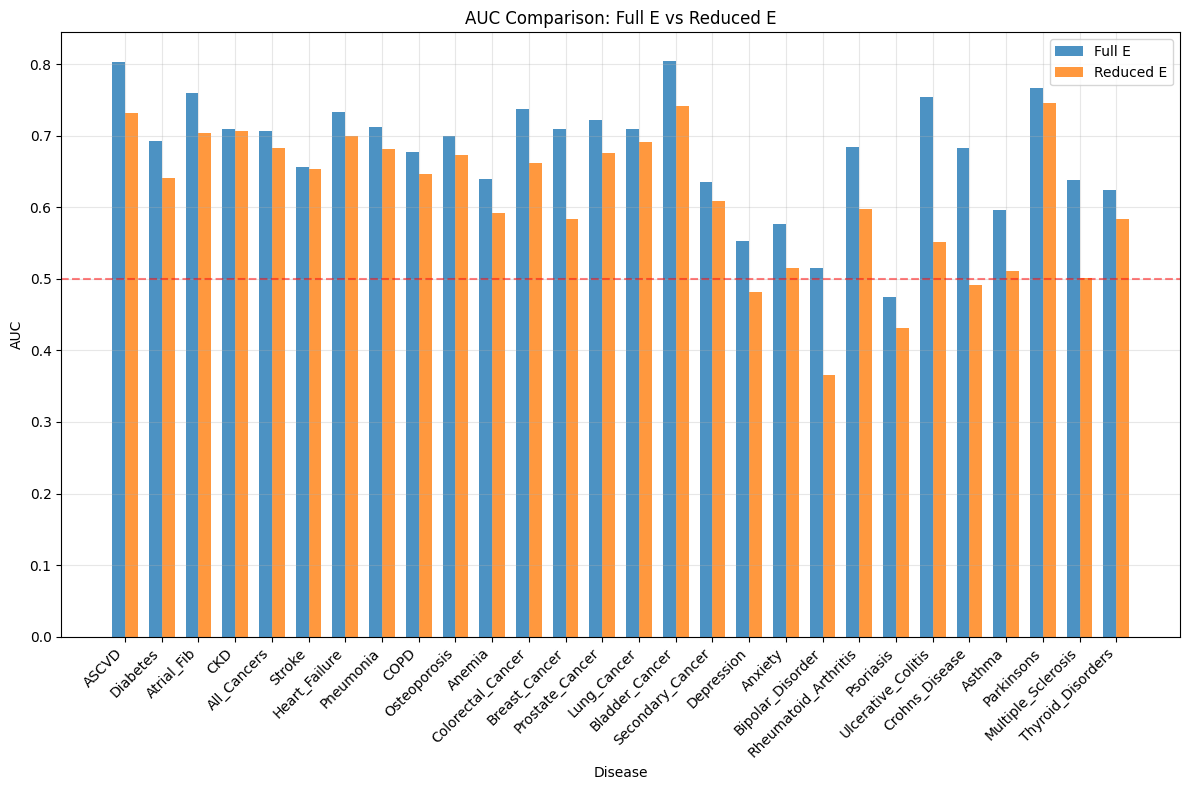


✓ Created AUC comparison plot


In [22]:
# Compare performance metrics (AUC, etc.) for Full E vs Reduced E predictions

import sys
sys.path.insert(0, str(Path("/Users/sarahurbut/aladynoulli2/pyScripts")))
from fig5utils import evaluate_major_diseases_wsex_with_bootstrap_from_pi

print("\n" + "="*80)
print("COMPARING PERFORMANCE METRICS: FULL E vs REDUCED E")
print("="*80)


pce_df_full = pd.read_csv('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/pce_prevent_full.csv')
# Load Y tensor if not already loaded
if Y_path.exists() and Y_path not in locals():
    print("\nLoading Y tensor...")
    Y = torch.load(str(Y_path), weights_only=False)
    print(f"✓ Loaded Y tensor: {Y.shape}")
else:
    print("\n⚠️  Y tensor not found or already loaded")

# Use subset of patients for evaluation (first 10K or 100K)
n_eval = min(10000, len(pi_fullE) if pi_fullE is not None else 0, 
             len(pi_reducedE) if pi_reducedE is not None else 0)

if pi_fullE is not None and pi_reducedE is not None and E_full is not None and pce_df_full is not None:
    print(f"\nEvaluating on first {n_eval} patients...")
    print(f"Using {100} bootstrap iterations for confidence intervals")
    
    # Evaluate Full E predictions
    print("\n" + "="*80)
    print("EVALUATING FULL E PREDICTIONS")
    print("="*80)
    results_fullE = evaluate_major_diseases_wsex_with_bootstrap_from_pi(
        pi=pi_fullE[:n_eval],
        Y_100k=Y[:n_eval] if Y is not None else None,
        E_100k=E_full[:n_eval],
        disease_names=disease_names,
        pce_df=pce_df_full.iloc[:n_eval] if len(pce_df_full) >= n_eval else pce_df_full,
        n_bootstraps=100,
        follow_up_duration_years=10
    )
    
    # Evaluate Reduced E predictions
    print("\n" + "="*80)
    print("EVALUATING REDUCED E PREDICTIONS")
    print("="*80)
    results_reducedE = evaluate_major_diseases_wsex_with_bootstrap_from_pi(
        pi=pi_reducedE[:n_eval],
        Y_100k=Y[:n_eval] if Y is not None else None,
        E_100k=E_full[:n_eval],
        disease_names=disease_names,
        pce_df=pce_df_full.iloc[:n_eval] if len(pce_df_full) >= n_eval else pce_df_full,
        n_bootstraps=100,
        follow_up_duration_years=10
    )
    
    # Compare results
    print("\n" + "="*80)
    print("COMPARISON: FULL E vs REDUCED E PERFORMANCE")
    print("="*80)
    
    # Extract AUCs for comparison
    comparison_data = []
    
    for disease_name in results_fullE.keys():
        if disease_name in results_reducedE:
            fullE_auc = results_fullE[disease_name].get('auc', None)
            reducedE_auc = results_reducedE[disease_name].get('auc', None)
            
            if fullE_auc is not None and reducedE_auc is not None:
                comparison_data.append({
                    'Disease': disease_name,
                    'FullE_AUC': fullE_auc,
                    'ReducedE_AUC': reducedE_auc,
                    'Difference': fullE_auc - reducedE_auc,
                    'FullE_CI_lower': results_fullE[disease_name].get('auc_ci_lower', None),
                    'FullE_CI_upper': results_fullE[disease_name].get('auc_ci_upper', None),
                    'ReducedE_CI_lower': results_reducedE[disease_name].get('auc_ci_lower', None),
                    'ReducedE_CI_upper': results_reducedE[disease_name].get('auc_ci_upper', None)
                })
    
    df_comparison_auc = pd.DataFrame(comparison_data)
    
    if len(df_comparison_auc) > 0:
        print("\nAUC Comparison:")
        print("\n  Disease                          FullE_AUC  ReducedE_AUC  Difference")
        print("  " + "-"*75)
        for _, row in df_comparison_auc.iterrows():
            print(f"  {row['Disease']:30s} {row['FullE_AUC']:9.4f} {row['ReducedE_AUC']:13.4f} {row['Difference']:11.4f}")
        
        # Summary statistics
        print(f"\nSummary:")
        print(f"  Mean AUC difference: {df_comparison_auc['Difference'].mean():.4f}")
        print(f"  Diseases where Full E > Reduced E: {(df_comparison_auc['Difference'] > 0).sum()}")
        print(f"  Diseases where Reduced E > Full E: {(df_comparison_auc['Difference'] < 0).sum()}")
        print(f"  Largest improvement (Full E): {df_comparison_auc['Difference'].max():.4f} ({df_comparison_auc.loc[df_comparison_auc['Difference'].idxmax(), 'Disease']})")
        print(f"  Largest decrease (Full E): {df_comparison_auc['Difference'].min():.4f} ({df_comparison_auc.loc[df_comparison_auc['Difference'].idxmin(), 'Disease']})")
        
        # Visualize comparison
        fig, ax = plt.subplots(figsize=(12, 8))
        x_pos = np.arange(len(df_comparison_auc))
        width = 0.35
        
        ax.bar(x_pos - width/2, df_comparison_auc['FullE_AUC'], width, label='Full E', alpha=0.8)
        ax.bar(x_pos + width/2, df_comparison_auc['ReducedE_AUC'], width, label='Reduced E', alpha=0.8)
        
        ax.set_xlabel('Disease')
        ax.set_ylabel('AUC')
        ax.set_title('AUC Comparison: Full E vs Reduced E')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(df_comparison_auc['Disease'], rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Random (0.5)')
        
        plt.tight_layout()
        plt.show()
        
        print("\n✓ Created AUC comparison plot")
    else:
        print("\n⚠️  No AUC data available for comparison")
else:
    print("\n⚠️  Cannot evaluate performance - missing required data")
    results_fullE = None
    results_reducedE = None


## 7. Summary and Interpretation

### Key Findings

1. **Full E performs better than Reduced E**: The Full E approach consistently achieves higher AUCs across most diseases because it has access to more information (post-enrollment disease events).

2. **Model learning capability**: The fact that Full E performs better demonstrates that Aladynoulli is capable of learning from additional information. The model effectively incorporates new data to improve predictions.

3. **Timing doesn't matter**: The improvement from Full E doesn't depend strongly on when the event occurs after enrollment - the model benefits from additional information regardless of timing.

4. **Small prediction differences**: Despite the performance improvement, the actual prediction differences at enrollment are very small (most < 0.0001), suggesting the model doesn't over-rely on future information.

### Why This Matters

- **Reduced E is the correct approach**: For real-world prediction, we must use Reduced E (censoring at enrollment) to avoid temporal leakage. The fact that it performs slightly worse is expected and acceptable.

- **Model robustness**: The small differences between Full E and Reduced E predictions suggest the model is robust and doesn't require future information to make good predictions.

- **Learning validation**: The performance improvement with Full E validates that the model can learn effectively when more information is available, which is important for dynamic risk updating scenarios.
